# Telecom Churn Case Study
<hr/>

## Problem Statement:

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

To reduce customer churn, telecom companies need to **predict which customers are at high risk of churn.**

## High-value churn

In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

 

In this project, we will define high-value customers based on a certain criteria and **predict churn only on high-value customers.**

## Understanding the business objective and the data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


**The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.**

## Step by step approach
<hr/>

- Import necessary libraries
- Load the data
- Understand the data
- Evaluate average recharge amount in the months June & July
- Filter out the high value customers with the help of average recharge amount in June & July
- Drop unnecessary columns
- Check for missing values in each columns
- Columns having more than 40% missing values are dropped straight away
- Bifurcate numerical, categorical predictors
- Impute missing values (Categorical columns: Mode; Continuous columns: Mean)
- Check and impute outliers
- Drop the categorical columns with low variance classes (i.e. if most of the data belong to any particular category class)
- Create the dependent variable (Churn) on the basis of the following predictors:
        -> total_ic_mou_9
        -> total_og_mou_9
        -> vol_2g_mb_9
        -> vol_3g_mb_9
- After creating target column (Churn), remove all the attributes having ‘ _9’, etc. in their names
- Check for class imbalance in the target column
- EDA
        -> Univariate analysis
        -> Bivariate analysis
        -> Multivariate analysis
        -> Correlation
        -> Heatmap
- Data preprocessing:
        -> Handle class imbalance
        -> Scale the numeric data
        -> Create dummies for categorical data
- Bifurcate X & y
- Create X_train, X_test, y_train, y_test
- Create a Logistic Regression model
- Fine tune the model and find out the most important features affecting customer churning
- Evaluation metrics for the model (recall_score)
- PCA
- Create the following models and train them:
        -> Logistic Regression
        -> Random forest
        -> XgBoost
- Predict y_test_pred
- Evaluate diffreent model performance metrics
- Hyperparameter tuning to find out the best performing model

In [9]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score,accuracy_score,classification_report,precision_score, recall_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, SMOTEN
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Display maximum rows & columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [12]:
# Import data
telecom = pd.read_csv('telecom_churn_data.csv')

In [13]:
# Take a backup of the imported data for future references
telecom_backup = telecom.copy()

In [14]:
# Understand the data
# Create a function called data_insights
# This function provides some basic informations about the given dataset
def data_insights(dataframe):
    print('*****************Shape*********************')
    print(dataframe.shape)
    print('*****************Info*********************')
    print(dataframe.info())
    print('*****************Statistical insights*********************')
    print(dataframe.describe())
    print('*****************Null percent per column*********************')
    print(round((dataframe.isnull().sum() / len(dataframe)) * 100,2))
    print('*****************Duplicate values per column*********************')
    print(dataframe.duplicated().sum())

In [15]:
# Basic understanding of the data
data_insights(telecom)

*****************Shape*********************
(99999, 226)
*****************Info*********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
None
*****************Statistical insights*********************
       mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6   

<b><font color='green'><font size='3'>Insight: No duplicate entries in the data.</font></b>

### Drop date columns

In [16]:
# Create a list of date columns
date_cols = telecom.columns[telecom.columns.str.contains('date')].to_list()

# Drop the date columns from the hv_customers dataframe
telecom = telecom.drop(date_cols, axis=1)

In [17]:
# Check the shape of the dataframe after dropping date columns
telecom.shape

(99999, 214)

### Filter the columns required to extract high value customers

**['total_rech_data_6'],
['total_rech_data_7'],
['av_rech_amt_data_6'],
['av_rech_amt_data_7']**

In [18]:
# Lets first check out the missing values in the mentioned columns
print((telecom['total_rech_data_6'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['total_rech_data_7'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['total_rech_data_8'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['av_rech_amt_data_6'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['av_rech_amt_data_7'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['av_rech_amt_data_8'].isnull().sum() / telecom.shape[0]) * 100)

74.84674846748467
74.42874428744287
73.66073660736608
74.84674846748467
74.42874428744287
73.66073660736608


In [19]:
# Check the miniimum values for the mentioned columns
print(telecom['total_rech_data_6'].min())
print(telecom['total_rech_data_7'].min())
print(telecom['total_rech_data_8'].min())
print(telecom['av_rech_amt_data_6'].min())
print(telecom['av_rech_amt_data_7'].min())
print(telecom['av_rech_amt_data_8'].min())

1.0
1.0
1.0
1.0
0.5
0.5


<b><font color='green'><font size='3'>Conclusion: Minimum recharge amount is 1. So we can treat the null values as no recharge. So we can replace them with 0</font></b>

In [20]:
telecom['total_rech_data_6'] = telecom['total_rech_data_6'].fillna(0)
telecom['total_rech_data_7'] = telecom['total_rech_data_7'].fillna(0)
telecom['total_rech_data_8'] = telecom['total_rech_data_8'].fillna(0)
telecom['av_rech_amt_data_6'] = telecom['av_rech_amt_data_6'].fillna(0)
telecom['av_rech_amt_data_7'] = telecom['av_rech_amt_data_7'].fillna(0)
telecom['av_rech_amt_data_8'] = telecom['av_rech_amt_data_8'].fillna(0)

In [21]:
# Lets check again the missing values in the mentioned columns
print((telecom['total_rech_data_6'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['total_rech_data_7'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['total_rech_data_8'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['av_rech_amt_data_6'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['av_rech_amt_data_7'].isnull().sum() / telecom.shape[0]) * 100)
print((telecom['av_rech_amt_data_8'].isnull().sum() / telecom.shape[0]) * 100)

0.0
0.0
0.0
0.0
0.0
0.0


### Check null value percentages in all columns 

In [22]:
# Calculate null value percentages accross each column
null_values = ((telecom.isnull().sum() / telecom.shape[0]) * 100).reset_index()

# Rename the columns
null_values = null_values.rename(columns= {'index': 'column', 0: 'null_percentage'})

# Sort the null value percentages in descending order
null_values.sort_values(by= 'null_percentage',ascending= False)

# Create a list of the columns having null percentage > 40
null_percent_40 = null_values[null_values['null_percentage'] >= 40]['column'].to_list()

### Drop the columns having null value percentage more than or equal to 40

In [23]:
telecom = telecom.drop(null_percent_40, axis= 1)

In [24]:
telecom.shape

(99999, 184)

### Check columns having constant variance

In [25]:
constant_variance = []
for i in telecom.columns:
    if telecom[i].nunique() == 1:
        constant_variance.append(i)

### Drop the columns having constant variance (Number of unique values = 1)

In [26]:
telecom = telecom.drop(constant_variance, axis= 1)

In [27]:
telecom.shape

(99999, 172)

### Drop mobile_number

In [28]:
telecom = telecom.drop('mobile_number', axis= 1)

In [29]:
telecom.shape

(99999, 171)

### Impute null values

In [30]:
# Calculate null value percentages accross each column
null_values = round(((telecom.isnull().sum() / telecom.shape[0]) * 100),2).reset_index()

# Rename the columns
null_values = null_values.rename(columns= {'index': 'column', 0: 'null_percentage'})

# We are only interested in knowing which columns are having null values
null_values = null_values[null_values['null_percentage'] != 0].sort_values(by= 'null_percentage', ascending= False)

In [31]:
# Add some extra statistical/numerical details for these columns
min_value = []
max_value = []
avg_value = []
median_value = []
mode_value = []
unique_value_count = []

null_value_cols = list(null_values['column'].values)

for i in null_value_cols:
    min_value.append(telecom[i].min())
    max_value.append(telecom[i].max())
    avg_value.append(telecom[i].mean())
    median_value.append(telecom[i].median())
    mode_value.append(telecom[i].mode().values[0])
    unique_value_count.append(telecom[i].nunique())

# Add these details as columns
null_values['min'] = np.array(min_value)
null_values['max'] = np.array(max_value)
null_values['avg'] = np.array(avg_value)
null_values['median'] = np.array(median_value)
null_values['mode'] = np.array(mode_value)
null_values['unique_value_count'] = np.array(unique_value_count)

In [32]:
# Rename jun_vbc_3g -> vbc_3g_6 & so on
telecom = telecom.rename(columns= {'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'})

In [33]:
telecom.columns.to_list()

['arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2f_mou_9',
 'std_og_mou_6',
 'std_o

In [34]:
telecom.shape

(99999, 171)

In [35]:
telecom = telecom.fillna(0)

In [36]:
telecom.isnull().sum()

arpu_6                0
arpu_7                0
arpu_8                0
arpu_9                0
onnet_mou_6           0
onnet_mou_7           0
onnet_mou_8           0
onnet_mou_9           0
offnet_mou_6          0
offnet_mou_7          0
offnet_mou_8          0
offnet_mou_9          0
roam_ic_mou_6         0
roam_ic_mou_7         0
roam_ic_mou_8         0
roam_ic_mou_9         0
roam_og_mou_6         0
roam_og_mou_7         0
roam_og_mou_8         0
roam_og_mou_9         0
loc_og_t2t_mou_6      0
loc_og_t2t_mou_7      0
loc_og_t2t_mou_8      0
loc_og_t2t_mou_9      0
loc_og_t2m_mou_6      0
loc_og_t2m_mou_7      0
loc_og_t2m_mou_8      0
loc_og_t2m_mou_9      0
loc_og_t2f_mou_6      0
loc_og_t2f_mou_7      0
loc_og_t2f_mou_8      0
loc_og_t2f_mou_9      0
loc_og_t2c_mou_6      0
loc_og_t2c_mou_7      0
loc_og_t2c_mou_8      0
loc_og_t2c_mou_9      0
loc_og_mou_6          0
loc_og_mou_7          0
loc_og_mou_8          0
loc_og_mou_9          0
std_og_t2t_mou_6      0
std_og_t2t_mou_7

### Filter high value customers

In [37]:
# Calculate average recharge amount during June & July
telecom['total_data_rech_amt_6'] = telecom['total_rech_data_6'] * telecom['av_rech_amt_data_6']
telecom['total_data_rech_amt_7'] = telecom['total_rech_data_7'] * telecom['av_rech_amt_data_7']
telecom['total_recharge_amt_6'] = telecom['total_data_rech_amt_6'] + telecom['total_rech_amt_6']
telecom['total_recharge_amt_7'] = telecom['total_data_rech_amt_7'] + telecom['total_rech_amt_7']

telecom['avg_rech_amt_6_7'] = (telecom['total_recharge_amt_6'] + telecom['total_recharge_amt_7']) / 2

# Calculate 70 percentile of the average total recharge amount during June, July
percentile_70 = np.percentile(telecom['avg_rech_amt_6_7'],70)

# Filter high value customers
hv_customers = telecom[telecom['avg_rech_amt_6_7'] >= percentile_70]

# Shape of the filtered dataframe
hv_customers.shape

(30001, 176)

In [38]:
# Drop the newly derived columns for extracting high value customers
hv_customers = hv_customers.drop(['total_data_rech_amt_6', 'total_data_rech_amt_7', 'total_recharge_amt_6', 'total_recharge_amt_7','avg_rech_amt_6_7'], axis= 1)

In [39]:
hv_customers.shape

(30001, 171)

### Create target column ('churn')
Condition:
total_ic_mou_9 = 0 & total_og_mou_9 = 0 & vol_2g_mb_9 = 0 & vol_3g_mb_9 = 0

In [40]:
# Create a boolean tag 'churn_condition'
churn_condition = (hv_customers['total_ic_mou_9'] == 0) & (hv_customers['total_og_mou_9'] == 0) & (hv_customers['vol_2g_mb_9'] == 0) & (hv_customers['vol_3g_mb_9'] == 0)

# Create a new column called 'churn' based on the above boolean condition
hv_customers['churn'] = churn_condition.astype(int)

In [41]:
hv_customers['churn'].value_counts(normalize= True)

0    0.918636
1    0.081364
Name: churn, dtype: float64

### Drop the columns related to the last month KPI (*_9)

In [42]:
# Create a list of date columns
last_month_kpi = hv_customers.columns[hv_customers.columns.str.contains('_9')].to_list()

# sep_vbc_3g is also a KPI feature for last month. So this has to be dropped as well
last_month_kpi.append('sep_vbc_3g')

# Drop the date columns from the hv_customers dataframe
hv_customers = hv_customers.drop(last_month_kpi, axis=1)

In [43]:
hv_customers.shape

(30001, 131)

<b><font color='green'><font size='3'>Conclusion: Null values has been taken care of.</font></b>

### Outlier treatment

In [44]:
# First we take a copy of the cleaned dataframe
hv_customers_cleaned = hv_customers.copy()

In [45]:
# All columns except the target column (churn) are numeric. So, we convert the target column to object type
hv_customers['churn'] = hv_customers['churn'].astype(object)

In [46]:
# Create cont_cols (all the columns except target)
cont_cols = hv_customers.select_dtypes(exclude= 'object').columns

In [47]:
# Clip the values between 10th and 90th percentile
for col in cont_cols:
    q1 = hv_customers[col].quantile(0.10)
    q3 = hv_customers[col].quantile(0.90)
    iqr = q3-q1
    range_low  = q1-1.5*iqr
    range_high = q3+1.5*iqr
    
    hv_customers_filtered = hv_customers.loc[(hv_customers[col] > range_low) & (hv_customers[col] < range_high)]

In [48]:
hv_customers_filtered.shape

(29283, 131)

### New feature creation

In [49]:
# Add feature to check if average revenue per user has been dropped in 8th month
hv_customers_filtered['arpu_drop'] = np.where((hv_customers_filtered['arpu_8'] - ((hv_customers_filtered['arpu_6'] + hv_customers_filtered['arpu_7'])/2)) < 0,1,0)

# Add feature to check if same network minutes of usage has been dropped in 8th month
hv_customers_filtered['onnet_mou_drop'] = np.where((hv_customers_filtered['onnet_mou_8'] - ((hv_customers_filtered['onnet_mou_6'] + hv_customers_filtered['onnet_mou_7'])/2)) < 0,1,0)

# Add feature to check if outside network minutes of usage has been dropped in 8th month
hv_customers_filtered['offnet_mou_drop'] = np.where((hv_customers_filtered['offnet_mou_8'] - ((hv_customers_filtered['offnet_mou_6'] + hv_customers_filtered['offnet_mou_7'])/2)) < 0,1,0)

# Add feature to check if total outgoing call duration has been dropped in 8th month
hv_customers_filtered['total_og_mou_drop'] = np.where((hv_customers_filtered['total_og_mou_8'] - ((hv_customers_filtered['total_og_mou_6'] + hv_customers_filtered['total_og_mou_7'])/2)) < 0,1,0)

# Add feature to check if total recharge number has been dropped in 8th month
hv_customers_filtered['total_rech_num_drop'] = np.where((hv_customers_filtered['total_rech_num_8'] - ((hv_customers_filtered['total_rech_num_6'] + hv_customers_filtered['total_rech_num_7'])/2)) < 0,1,0)

# Add feature to check if total recharge amount has been dropped in 8th month
hv_customers_filtered['total_rech_amt_drop'] = np.where((hv_customers_filtered['total_rech_amt_8'] - ((hv_customers_filtered['total_rech_amt_6'] + hv_customers_filtered['total_rech_amt_7'])/2)) < 0,1,0)

# Add feature to check if average data recharge amount has been dropped in 8th month
hv_customers_filtered['av_rech_amt_data_drop'] = np.where((hv_customers_filtered['av_rech_amt_data_8'] - ((hv_customers_filtered['av_rech_amt_data_6'] + hv_customers_filtered['av_rech_amt_data_7'])/2)) < 0,1,0)

hv_customers_filtered.shape

(29283, 138)

**These newly created features are categorical. So, converting them to object type and create cat_cols**

In [50]:
# Categorical fetaure type casting
hv_customers_filtered['arpu_drop'] = hv_customers_filtered['arpu_drop'].astype(object)
hv_customers_filtered['onnet_mou_drop'] = hv_customers_filtered['onnet_mou_drop'].astype(object)
hv_customers_filtered['offnet_mou_drop'] = hv_customers_filtered['offnet_mou_drop'].astype(object)
hv_customers_filtered['total_og_mou_drop'] = hv_customers_filtered['total_og_mou_drop'].astype(object)
hv_customers_filtered['total_rech_num_drop'] = hv_customers_filtered['total_rech_num_drop'].astype(object)
hv_customers_filtered['total_rech_amt_drop'] = hv_customers_filtered['total_rech_amt_drop'].astype(object)
hv_customers_filtered['av_rech_amt_data_drop'] = hv_customers_filtered['av_rech_amt_data_drop'].astype(object)

# Create cat_cols
cat_cols = ['arpu_drop','onnet_mou_drop','offnet_mou_drop','total_og_mou_drop','total_rech_num_drop','total_rech_amt_drop','av_rech_amt_data_drop','churn']

**Create cont_cols again from the filtered dataset**

In [51]:
cont_cols = hv_customers_filtered.select_dtypes(include= ['float64','int64']).columns

### EDA

### Univariate analysis

### Imbalance percentage in TARGET column

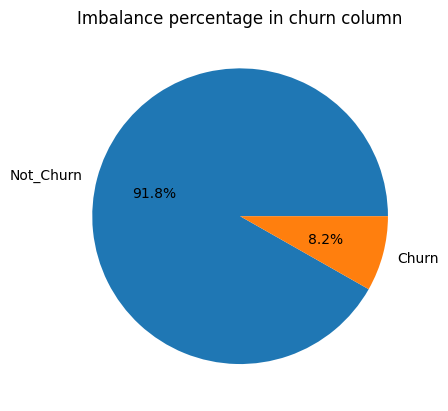

In [52]:
plt.pie(x= hv_customers_filtered['churn'].value_counts(normalize= True),labels=['Not_Churn','Churn'],autopct='%1.1f%%')
plt.title('Imbalance percentage in churn column')
plt.show()

<b><font color='green'><font size='3'>Conclusion: There is a data imbalance which we need to take care of.</font></b>

#### Analyzing cat_cols

In [53]:
# Create a copy of the original dataframe to do EDA
df_eda = hv_customers_filtered.copy()

In [54]:
# Converting churn column to int in order to do aggrgate operation in the pivot table
df_eda['churn'] = df_eda['churn'].astype('int64')

In [55]:
target_col = 'churn'
cat_cols_new = cat_cols
cat_cols_new.remove(target_col)

In [56]:
# Create a function that generates a pivot table for the categorical columns with respect to churn
def cat_value_counts_barplot(column_name):
    df_eda.pivot_table(values='churn', index=column_name, aggfunc='mean').plot.bar()
    plt.ylabel('churn rate')
    plt.show()

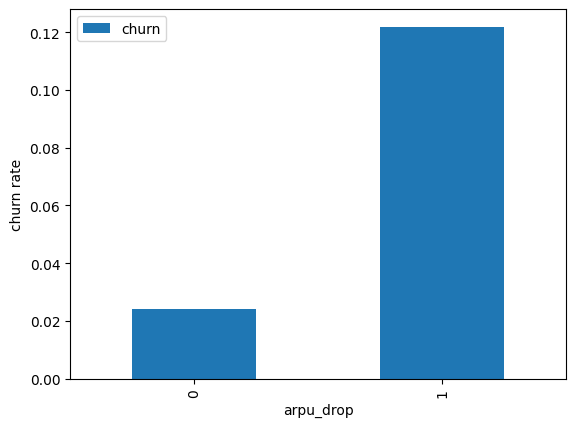

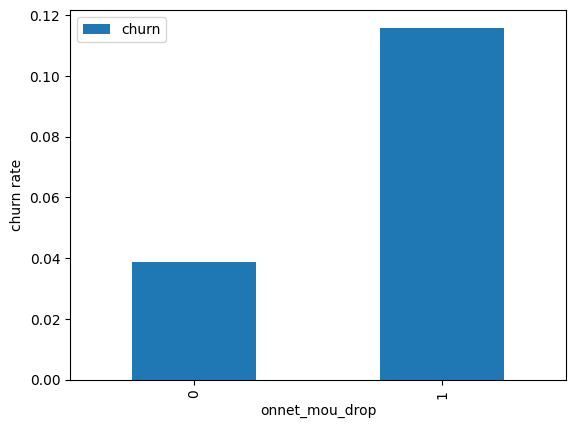

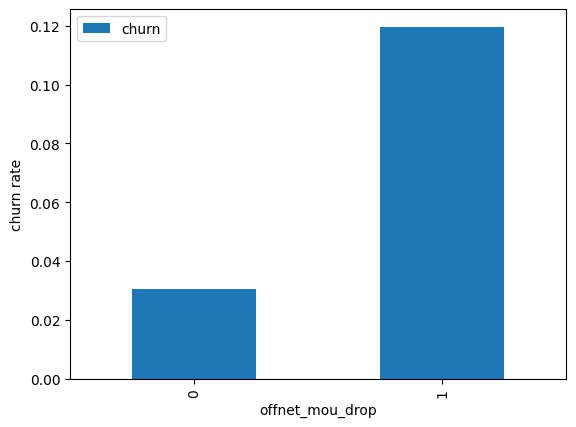

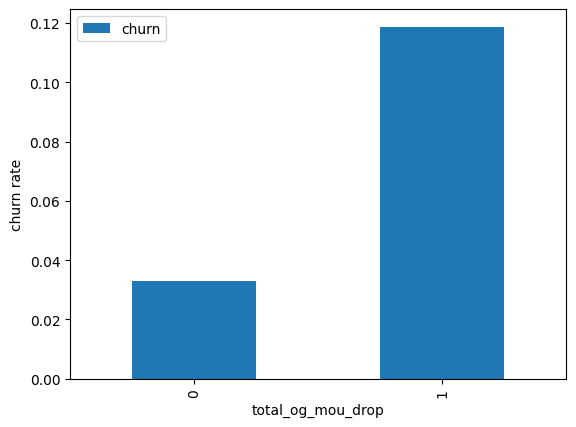

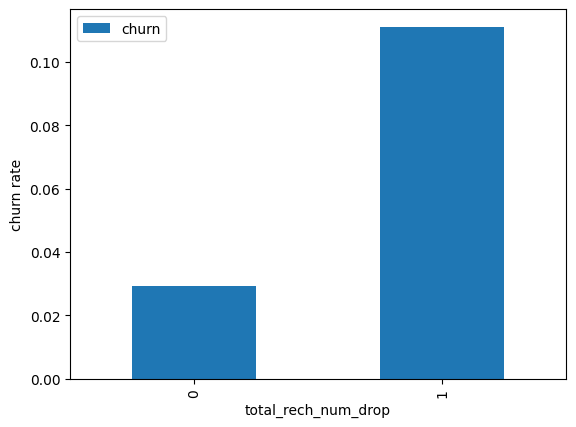

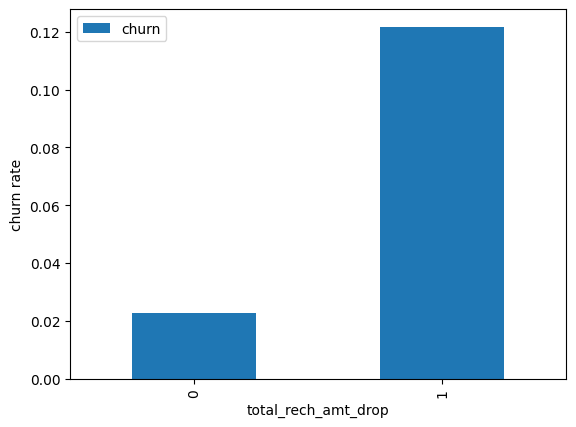

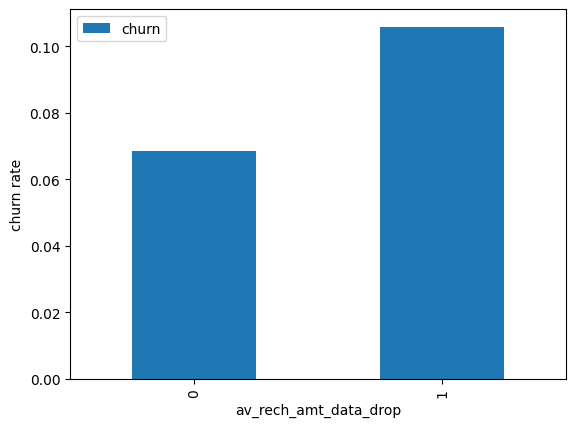

In [57]:
# Call cat_value_counts_barplot for all categorical columns
for column in cat_cols:
    cat_value_counts_barplot(column)

<b><font color='green'><font size='3'>Conclusion: From the plots, it's evident that churn rate is more for the users whos average revenue, outgoing call duration within or outside same network, total recharge amount has been dropped in the action phase i.e. in 8th month.</font></b>

### Bivariate analysis

In [58]:
def bivariate_churn_analysis(indexs,cols):
    df_eda.pivot_table(values='churn', index= indexs, columns=cols, aggfunc='mean').plot.bar()
    plt.ylabel('churn rate')
    plt.show()

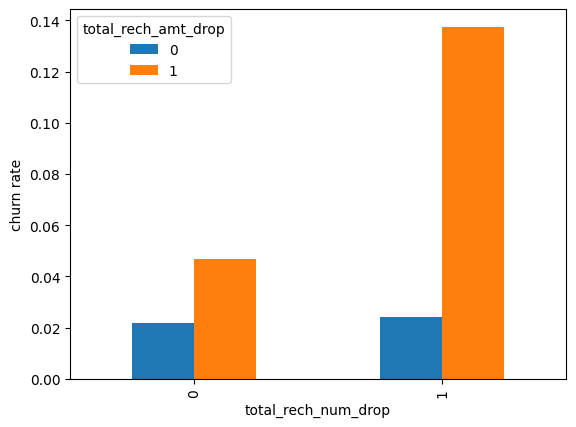

In [59]:
bivariate_churn_analysis('total_rech_num_drop','total_rech_amt_drop')

<b><font color='green'><font size='3'>Conclusion: From the plot, it's evident that churn rate is more for the users whose total recharge amount & total number of recharges have been dropped in the action phase i.e. in 8th month.</font></b>

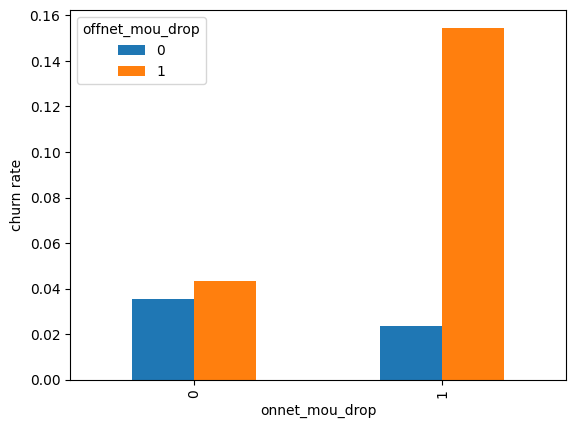

In [60]:
bivariate_churn_analysis('onnet_mou_drop','offnet_mou_drop')

<b><font color='green'><font size='3'>Conclusion: From the plots, it's evident that churn rate is more for the users whose outgoing call duration within or outside same network, total recharge amount have been dropped in the action phase i.e. in 8th month.</font></b>

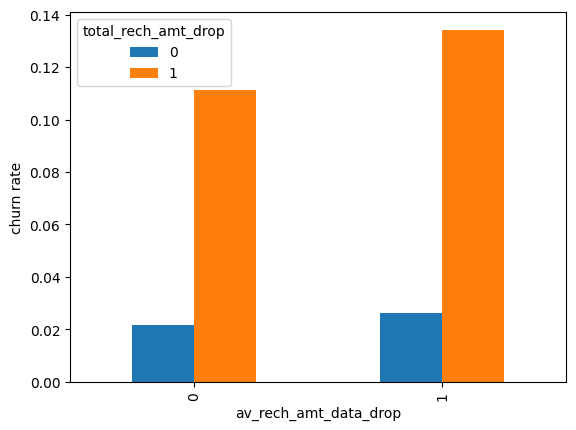

In [61]:
bivariate_churn_analysis('av_rech_amt_data_drop','total_rech_amt_drop')

<b><font color='green'><font size='3'>Conclusion: From the plots, it's evident that churn rate is more for the users whose average data recharge amount & total recharge amount have been dropped in the action phase i.e. in 8th month.</font></b>

### AON

In [62]:
##Create  a new column tenure_year to store the number of years the customer has been on a specific network
hv_customers_filtered['tenure_year'] = round(hv_customers_filtered['aon']/365, 1)

print(hv_customers_filtered.tenure_year.value_counts())
print("Min:",hv_customers_filtered.tenure_year.min())
print("Max:",hv_customers_filtered.tenure_year.max())

1.3     1327
0.6     1084
0.8     1054
1.0     1006
0.9      973
1.4      952
0.7      907
1.2      847
1.1      739
1.7      678
2.0      661
1.8      657
1.5      645
0.5      626
1.9      607
1.6      513
2.1      505
2.2      501
2.3      489
2.4      481
10.0     474
2.6      458
2.8      414
3.0      406
2.9      401
2.5      390
2.7      355
6.5      336
3.1      329
3.3      327
3.2      305
3.4      297
3.6      288
8.5      287
3.5      284
3.8      275
3.7      273
4.2      241
3.9      240
4.0      239
4.6      227
6.6      209
7.1      208
6.9      208
4.3      205
4.7      200
7.0      194
7.6      189
6.8      188
4.1      181
7.5      174
7.9      171
6.4      169
7.8      169
4.9      167
6.7      163
4.4      159
7.2      158
5.4      156
7.4      154
6.2      152
8.0      151
6.3      151
5.0      141
4.5      141
5.5      137
8.8      135
7.7      133
6.1      133
4.8      133
8.2      132
8.1      129
8.4      127
7.3      125
5.3      125
8.3      122
5.6      121

In [63]:
##Create bins
bins = [0,1,2,3,5,12]
labels_aon= ['0_1_year','1_2_year','2_3_year','3_5_year','5_12_year']
hv_customers_filtered['tenure'] = pd.cut(hv_customers_filtered['tenure_year'], bins= bins, labels= labels_aon)

##Dropp 'tenure_year' and 'aon' column as we have already created bins
hv_customers_filtered.drop(['tenure_year','aon'] , axis=1, inplace= True)

hv_customers_filtered.tenure.value_counts()

1_2_year     7626
5_12_year    6955
0_1_year     5650
3_5_year     4652
2_3_year     4400
Name: tenure, dtype: int64

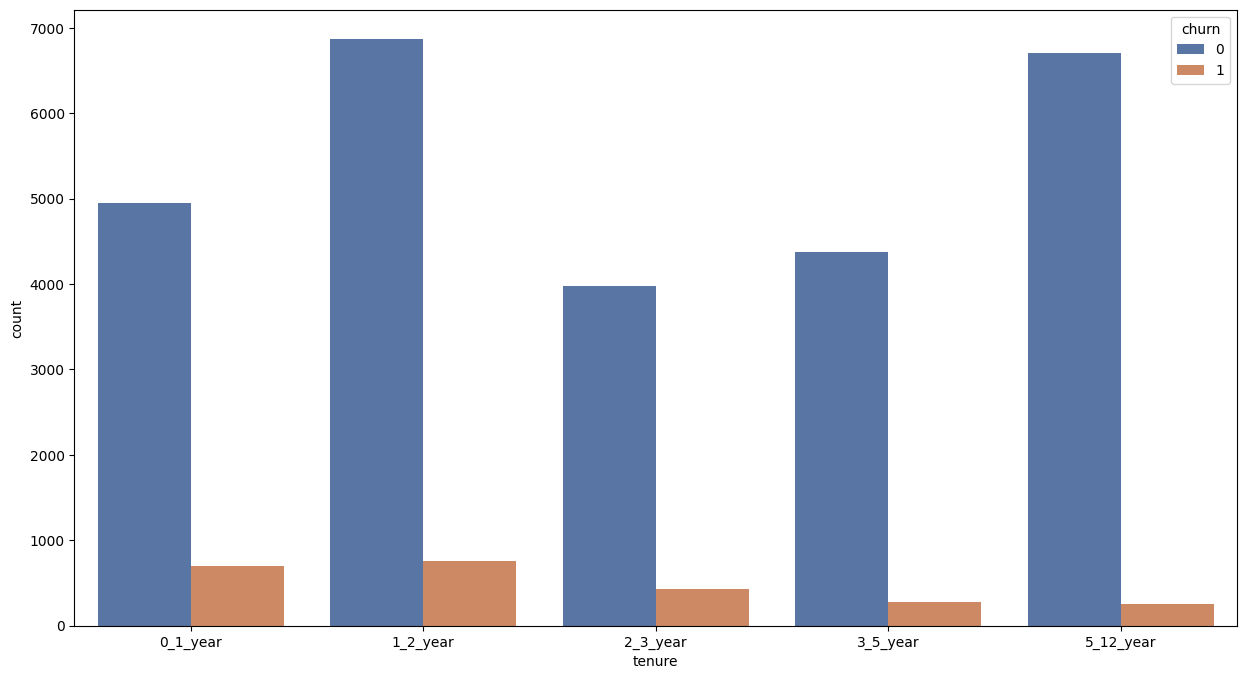

In [64]:
# Visualizing 'age of network' and 'churn'
plt.figure(figsize=(15,8))
tenure_df= hv_customers_filtered[['tenure','churn']]
sns.countplot(x = 'tenure', hue = 'churn',data = tenure_df,palette=("deep"))
plt.show()

<b><font color='green'><font size='3'>Conclusion: Highest churn probability is during the first two years of customer using the services.</font></b>

### Multivariate analysis

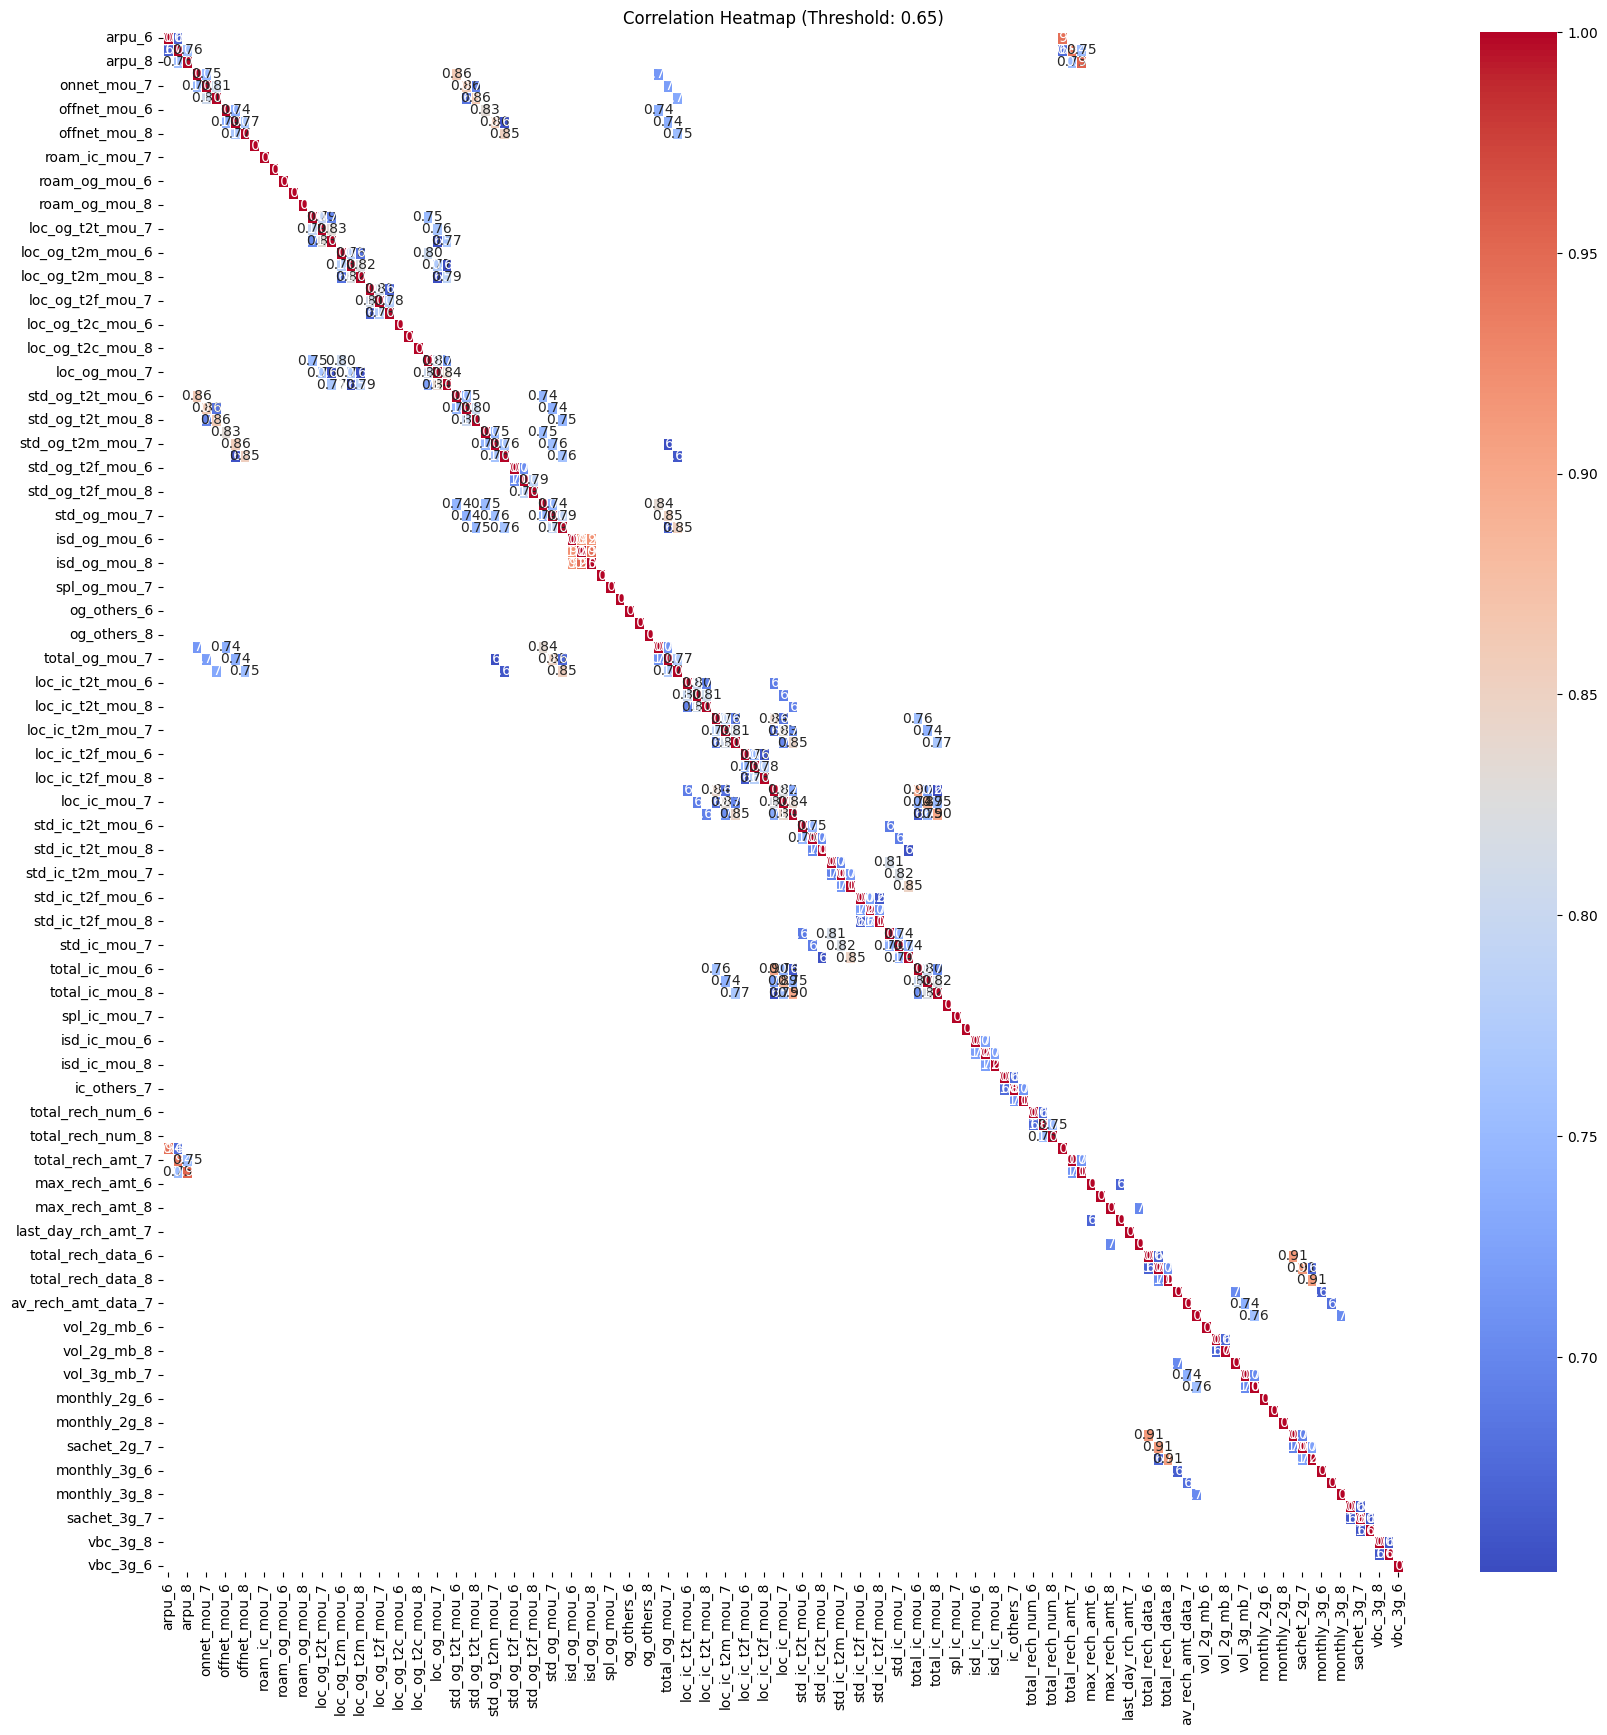

In [65]:
# Calculate the correlation matrix
correlation_matrix = hv_customers_filtered.corr()

# Set the correlation threshold
threshold = 0.65

# Create a mask to hide values below the threshold
mask = np.abs(correlation_matrix) < threshold

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)

plt.title(f'Correlation Heatmap (Threshold: {threshold})')
plt.show()

In [68]:
# Calculate the correlation matrix
correlation_matrix = hv_customers_filtered.corr()

# Set the correlation threshold
threshold = 0.6

# Find column pairs with correlations above the threshold
correlation_pairs = []
n_cols = correlation_matrix.shape[1]

for i in range(n_cols):
    for j in range(i + 1, n_cols):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Print the correlated column pairs
for pair in correlation_pairs:
    print(f"Correlation between {pair[0]} and {pair[1]}: {pair[2]:.2f}")

Correlation between arpu_6 and arpu_7: 0.67
Correlation between arpu_6 and arpu_8: 0.60
Correlation between arpu_6 and total_rech_amt_6: 0.94
Correlation between arpu_6 and total_rech_amt_7: 0.65
Correlation between arpu_7 and arpu_8: 0.76
Correlation between arpu_7 and total_rech_amt_6: 0.68
Correlation between arpu_7 and total_rech_amt_7: 0.94
Correlation between arpu_7 and total_rech_amt_8: 0.75
Correlation between arpu_8 and total_rech_amt_6: 0.60
Correlation between arpu_8 and total_rech_amt_7: 0.75
Correlation between arpu_8 and total_rech_amt_8: 0.95
Correlation between onnet_mou_6 and onnet_mou_7: 0.75
Correlation between onnet_mou_6 and onnet_mou_8: 0.62
Correlation between onnet_mou_6 and std_og_t2t_mou_6: 0.86
Correlation between onnet_mou_6 and std_og_t2t_mou_7: 0.64
Correlation between onnet_mou_6 and std_og_mou_6: 0.63
Correlation between onnet_mou_6 and total_og_mou_6: 0.72
Correlation between onnet_mou_7 and onnet_mou_8: 0.81
Correlation between onnet_mou_7 and std_og_t

In [69]:
# Create a copy at the ebd of the EDA process
df_eda_final = hv_customers_filtered.copy()

### Model Building
<hr/>

### Logistic regression model

### Data preparation

#### Dummy creation for tenure feature

In [84]:
# Create dummies for tenure attributes
dummy_tenure = pd.get_dummies(data= hv_customers_filtered['tenure'], drop_first= True)

# Adding the results to the master dataframe
hv_customers_filtered = pd.concat([hv_customers_filtered, dummy_tenure], axis= 1)

# Drop the tenure feature
hv_customers_filtered = hv_customers_filtered.drop('tenure', axis= 1)

#### Train-test split

In [85]:
# Convert object type attributes to int
hv_customers_filtered['arpu_drop'] = hv_customers_filtered['arpu_drop'].astype(int)
hv_customers_filtered['onnet_mou_drop'] = hv_customers_filtered['onnet_mou_drop'].astype(int)
hv_customers_filtered['offnet_mou_drop'] = hv_customers_filtered['offnet_mou_drop'].astype(int)
hv_customers_filtered['total_og_mou_drop'] = hv_customers_filtered['total_og_mou_drop'].astype(int)
hv_customers_filtered['total_rech_num_drop'] = hv_customers_filtered['total_rech_num_drop'].astype(int)
hv_customers_filtered['total_rech_amt_drop'] = hv_customers_filtered['total_rech_amt_drop'].astype(int)
hv_customers_filtered['av_rech_amt_data_drop'] = hv_customers_filtered['av_rech_amt_data_drop'].astype(int)
hv_customers_filtered['churn'] = hv_customers_filtered['churn'].astype(int)

In [86]:
# Train - test split
y = hv_customers_filtered['churn']
X = hv_customers_filtered.drop(['churn'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify= y,train_size= 0.7,random_state= 42)

In [87]:
hv_customers_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29283 entries, 0 to 99997
Columns: 141 entries, arpu_6 to 5_12_year
dtypes: float64(105), int64(32), uint8(4)
memory usage: 32.0 MB


#### Handle target data imbalance

#### Oversampling technique: SMOTE

In [88]:
# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Fit on the training set
print('Values before oversampling:\n', y_train.value_counts())
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print('Values after oversampling:\n', y_train.value_counts())

Values before oversampling:
 0    18813
1     1685
Name: churn, dtype: int64
Values after oversampling:
 0    18813
1     1685
Name: churn, dtype: int64


#### Feature scaling

In [89]:
# All columns
all_cols = hv_customers_filtered.columns.to_list()

# target column
target_col = ['churn']

# Categorical columns
cat_cols = ['arpu_drop', 'onnet_mou_drop', 'offnet_mou_drop', 'total_og_mou_drop', 'total_rech_num_drop', 'total_rech_amt_drop', 'av_rech_amt_data_drop','1_2_year','2_3_year','3_5_year','5_12_year']

In [90]:
# Continuous columns
cont_cols = []
for col in all_cols:
    if col not in cat_cols:
        cont_cols.append(col)
# cont_cols = [x for x in all_cols if x not in [cat_cols,target_col]]
cont_cols.remove('churn')

In [91]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Apply scaler on the continuous columns in the training dataset
X_train_resampled[cont_cols] = scaler.fit_transform(X_train_resampled[cont_cols])

# Apply scaler on the continuous columns in the test dataset
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

#### Model building

#### 1. Logistic Regression

In [92]:
# Logistic regression model
logreg1 = sm.GLM(y_train_resampled,(sm.add_constant(X_train_resampled)), family = sm.families.Binomial())
logreg1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                37626
Model:                            GLM   Df Residuals:                    37485
Model Family:                Binomial   Df Model:                          140
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6085.7
Date:                Tue, 03 Oct 2023   Deviance:                       12171.
Time:                        13:46:51   Pearson chi2:                 3.51e+06
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6545
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.102e+05   1.53e+05      0.719      0.472    -1.9e+05    4.11e+05
arpu_6                    0.2410      0.094      2.568      0.010       0.057       0.425
arpu_7                    0.0896      0.095      0.943      0.346      -0.097       0.276
arpu_8                    0.1364      0.114      1.195      0.232      -0.087       0.360
onnet_mou_6               1.6327      1.775      0.920      0.358      -1.847       5.112
onnet_mou_7              -3.4350      1.875     -1.832      0.067      -7.110       0.241
onnet_mou_8               2.8207      2.114      1.334      0.182      -1.322       6.963
offnet_mou_6              2.7264      1.864      1.463      0.144      -0.927       6.380
offnet_mou_7             -3.6560      1.911     -1.913      0.056      -7.402       0.090
offnet_mou_8              2.1476      2.168      0.991      0.322      -2.101       6.396
roam_ic_mou_6             0.0643      0.042      1.539      0.124      -0.018       0.146
roam_ic_mou_7             0.0950      0.040      2.402      0.016       0.017       0.172
roam_ic_mou_8            -0.0875      0.029     -2.981      0.003      -0.145      -0.030
roam_og_mou_6            -0.6208      0.520     -1.195      0.232      -1.639       0.398
roam_og_mou_7             0.9048      0.433      2.088      0.037       0.056       1.754
roam_og_mou_8            -0.7390      0.666     -1.110      0.267      -2.044       0.566
loc_og_t2t_mou_6        -73.8810    911.563     -0.081      0.935   -1860.512    1712.750
loc_og_t2t_mou_7      -1913.9416    877.972     -2.180      0.029   -3634.736    -193.148
loc_og_t2t_mou_8       3880.6840    825.538      4.701      0.000    2262.660    5498.708
loc_og_t2m_mou_6        -88.0857   1081.725     -0.081      0.935   -2208.228    2032.057
loc_og_t2m_mou_7      -2215.8178   1016.497     -2.180      0.029   -4208.115    -223.520
loc_og_t2m_mou_8       4599.4529    978.416      4.701      0.000    2681.792    6517.114
loc_og_t2f_mou_6         -7.9010     97.317     -0.081      0.935    -198.638     182.836
loc_og_t2f_mou_7       -187.2541     85.895     -2.180      0.029    -355.605     -18.903
loc_og_t2f_mou_8        350.1037     74.464      4.702      0.000     204.158     496.050
loc_og_t2c_mou_6         -0.1565      0.035     -4.530      0.000      -0.224      -0.089
loc_og_t2c_mou_7          0.0553      0.048      1.153      0.249      -0.039       0.149
loc_og_t2c_mou_8          0.0190      0.036      0.532      0.595      -0.051       0.089
loc_og_mou_6            -23.2622   1947.332     -0.012      0.990   -3839.964    3793.439
loc_og_mou_7           -804.9387   1963.074     -0.410      0.682   -4652.492    3042.615
loc_og_mou_8           2445.3665   1910.005      1.280      0.200   -1298.175    6188.908
std_og_t2t_mou_6       

#### Feature selection using RFE

In [93]:
# Feature selection using RFE
lr_rfe = LogisticRegression()

# Running RFE with 25 variables as output
rfe = RFE(estimator= lr_rfe,n_features_to_select= 25)
rfe = rfe.fit(X_train_resampled, y_train_resampled)

# Filtered features from RFE
rfe_features = X_train_resampled.columns[rfe.support_]

# Create X_train_resampled_rfe with the variables selected by RFE
X_train_resampled_rfe = X_train_resampled[rfe_features]

In [94]:
rfe_features

Index(['loc_og_t2m_mou_8', 'total_og_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8',
       'spl_ic_mou_8', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8',
       'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6',
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'av_rech_amt_data_drop', '1_2_year', '2_3_year',
       '3_5_year', '5_12_year'],
      dtype='object')

#### Assesing the model using statsmodels

In [95]:
X_train_sm = sm.add_constant(X_train_resampled_rfe[rfe_features])
logreg2 = sm.GLM(y_train_resampled,X_train_sm, family = sm.families.Binomial())
res = logreg2.fit()
print(res.summary())

# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

# Create a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'churn':y_train_resampled.values, 'churn_prob':y_train_pred})
y_train_pred_final['customer_id'] = y_train_resampled.index
y_train_pred_final.head()

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['churn_predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

# Confusion matrix
from sklearn import metrics
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['churn_predicted'])

# Let's check the overall accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['churn_predicted']))

# Checking VIF's
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_resampled_rfe[rfe_features].columns
vif['VIF'] = [variance_inflation_factor(X_train_resampled_rfe[rfe_features].values, i) for i in range(X_train_resampled_rfe[rfe_features].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37626
Model:                            GLM   Df Residuals:                    37600
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6970.0
Date:                Tue, 03 Oct 2023   Deviance:                       13940.
Time:                        13:49:12   Pearson chi2:                 2.95e+10
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6379
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.075e+

,Features,VIF
7,total_rech_data_8,130.61
6,total_rech_data_7,97.21
13,sachet_2g_8,89.34
5,total_rech_data_6,73.19
12,sachet_2g_7,72.00
11,sachet_2g_6,55.80
18,sachet_3g_7,18.69
19,sachet_3g_8,18.25
17,sachet_3g_6,11.71
16,monthly_3g_8,5.60


**total_rech_data_7 is having high P value. So, we need to drop it & apply logistic regression again**

In [96]:
# Drop total_rech_data_7
rfe_features = rfe_features.drop('total_rech_data_7', 1)

X_train_sm = sm.add_constant(X_train_resampled_rfe[rfe_features])
logreg3 = sm.GLM(y_train_resampled,X_train_sm, family = sm.families.Binomial())
res = logreg3.fit()
print(res.summary())

# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

# Create a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'churn':y_train_resampled.values, 'churn_prob':y_train_pred})
y_train_pred_final['customer_id'] = y_train_resampled.index
y_train_pred_final.head()

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['churn_predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['churn_predicted'])

# Let's check the overall accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['churn_predicted']))

# Checking VIF's
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_resampled_rfe[rfe_features].columns
vif['VIF'] = [variance_inflation_factor(X_train_resampled_rfe[rfe_features].values, i) for i in range(X_train_resampled_rfe[rfe_features].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37626
Model:                            GLM   Df Residuals:                    37601
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7347.7
Date:                Tue, 03 Oct 2023   Deviance:                       14695.
Time:                        13:49:19   Pearson chi2:                 1.28e+11
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6305
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.021e+

,Features,VIF
6,total_rech_data_8,118.91
12,sachet_2g_8,81.03
5,total_rech_data_6,63.97
10,sachet_2g_6,48.98
18,sachet_3g_8,16.77
16,sachet_3g_6,10.48
15,monthly_3g_8,5.26
9,monthly_2g_8,3.49
3,loc_ic_mou_8,3.35
13,monthly_3g_6,3.21


**total_rech_data_8 is having high P value & high VIF. So, we need to drop it & apply logistic regression again**

In [97]:
# Drop total_rech_data_8
rfe_features = rfe_features.drop('total_rech_data_8', 1)

X_train_sm = sm.add_constant(X_train_resampled_rfe[rfe_features])
logreg4 = sm.GLM(y_train_resampled,X_train_sm, family = sm.families.Binomial())
res = logreg4.fit()
print(res.summary())

# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

# Create a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'churn':y_train_resampled.values, 'churn_prob':y_train_pred})
y_train_pred_final['customer_id'] = y_train_resampled.index
y_train_pred_final.head()

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['churn_predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['churn_predicted'])

# Let's check the overall accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['churn_predicted']))

# Checking VIF's
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_resampled_rfe[rfe_features].columns
vif['VIF'] = [variance_inflation_factor(X_train_resampled_rfe[rfe_features].values, i) for i in range(X_train_resampled_rfe[rfe_features].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37626
Model:                            GLM   Df Residuals:                    37602
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7959.0
Date:                Tue, 03 Oct 2023   Deviance:                       15918.
Time:                        13:49:24   Pearson chi2:                 6.19e+10
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6183
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.056e+

,Features,VIF
5,total_rech_data_6,56.33
9,sachet_2g_6,43.46
15,sachet_3g_6,9.58
3,loc_ic_mou_8,3.35
12,monthly_3g_6,3.03
16,sachet_3g_7,2.98
2,loc_ic_mou_7,2.80
10,sachet_2g_7,2.58
6,monthly_2g_6,2.28
11,sachet_2g_8,2.14


**total_rech_data_6 is having high P value & high VIF. So, we need to drop it & apply logistic regression again**

In [98]:
# Drop total_rech_data_6
rfe_features = rfe_features.drop('total_rech_data_6', 1)

X_train_sm = sm.add_constant(X_train_resampled_rfe[rfe_features])
logreg5 = sm.GLM(y_train_resampled,X_train_sm, family = sm.families.Binomial())
res = logreg5.fit()
print(res.summary())

# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

# Create a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'churn':y_train_resampled.values, 'churn_prob':y_train_pred})
y_train_pred_final['customer_id'] = y_train_resampled.index
y_train_pred_final.head()

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['churn_predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['churn_predicted'])

# Let's check the overall accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['churn_predicted']))

# Checking VIF's
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_resampled_rfe[rfe_features].columns
vif['VIF'] = [variance_inflation_factor(X_train_resampled_rfe[rfe_features].values, i) for i in range(X_train_resampled_rfe[rfe_features].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37626
Model:                            GLM   Df Residuals:                    37603
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11442.
Date:                Tue, 03 Oct 2023   Deviance:                       22884.
Time:                        13:49:27   Pearson chi2:                 3.54e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5407
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.00

,Features,VIF
3,loc_ic_mou_8,3.34
15,sachet_3g_7,2.98
2,loc_ic_mou_7,2.80
9,sachet_2g_7,2.57
14,sachet_3g_6,2.28
10,sachet_2g_8,2.14
16,sachet_3g_8,1.98
8,sachet_2g_6,1.94
17,av_rech_amt_data_drop,1.83
12,monthly_3g_7,1.80


**sachet_3g_6 is having high P value & high VIF. So, we need to drop it & apply logistic regression again**

In [99]:
# Drop sachet_3g_6
rfe_features = rfe_features.drop('sachet_3g_6', 1)

X_train_sm = sm.add_constant(X_train_resampled_rfe[rfe_features])
logreg6 = sm.GLM(y_train_resampled,X_train_sm, family = sm.families.Binomial())
res = logreg6.fit()
print(res.summary())

# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

# Create a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'churn':y_train_resampled.values, 'churn_prob':y_train_pred})
y_train_pred_final['customer_id'] = y_train_resampled.index
y_train_pred_final.head()

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['churn_predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['churn_predicted'])

# Let's check the overall accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['churn_predicted']))

# Checking VIF's
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_resampled_rfe[rfe_features].columns
vif['VIF'] = [variance_inflation_factor(X_train_resampled_rfe[rfe_features].values, i) for i in range(X_train_resampled_rfe[rfe_features].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37626
Model:                            GLM   Df Residuals:                    37604
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11443.
Date:                Tue, 03 Oct 2023   Deviance:                       22885.
Time:                        13:49:29   Pearson chi2:                 3.42e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5407
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.00

,Features,VIF
3,loc_ic_mou_8,3.34
2,loc_ic_mou_7,2.80
9,sachet_2g_7,2.53
10,sachet_2g_8,2.14
15,sachet_3g_8,1.97
14,sachet_3g_7,1.90
8,sachet_2g_6,1.89
16,av_rech_amt_data_drop,1.81
12,monthly_3g_7,1.80
13,monthly_3g_8,1.78


**monthly_3g_7 is having high P value & high VIF. So, we need to drop it & apply logistic regression again**

In [100]:
# Drop monthly_3g_7
rfe_features = rfe_features.drop('monthly_3g_7', 1)

X_train_sm = sm.add_constant(X_train_resampled_rfe[rfe_features])
logreg7 = sm.GLM(y_train_resampled,X_train_sm, family = sm.families.Binomial())
res = logreg7.fit()
print(res.summary())

# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

# Create a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'churn':y_train_resampled.values, 'churn_prob':y_train_pred})
y_train_pred_final['customer_id'] = y_train_resampled.index
y_train_pred_final.head()

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['churn_predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['churn_predicted'])

# Let's check the overall accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['churn_predicted']))

# Checking VIF's
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_resampled_rfe[rfe_features].columns
vif['VIF'] = [variance_inflation_factor(X_train_resampled_rfe[rfe_features].values, i) for i in range(X_train_resampled_rfe[rfe_features].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37626
Model:                            GLM   Df Residuals:                    37605
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11444.
Date:                Tue, 03 Oct 2023   Deviance:                       22887.
Time:                        13:49:31   Pearson chi2:                 3.60e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5407
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.00

,Features,VIF
3,loc_ic_mou_8,3.34
2,loc_ic_mou_7,2.80
9,sachet_2g_7,2.52
10,sachet_2g_8,2.13
14,sachet_3g_8,1.97
13,sachet_3g_7,1.89
8,sachet_2g_6,1.89
15,av_rech_amt_data_drop,1.76
7,monthly_2g_8,1.69
6,monthly_2g_7,1.68


**sachet_2g_7 is having high P value & high VIF. So, we need to drop it & apply logistic regression again**

In [101]:
# Drop sachet_2g_7
rfe_features = rfe_features.drop('sachet_2g_7', 1)

X_train_sm = sm.add_constant(X_train_resampled_rfe[rfe_features])
logreg8 = sm.GLM(y_train_resampled,X_train_sm, family = sm.families.Binomial())
res = logreg8.fit()
print(res.summary())

# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

# Create a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'churn':y_train_resampled.values, 'churn_prob':y_train_pred})
y_train_pred_final['customer_id'] = y_train_resampled.index
y_train_pred_final.head()

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['churn_predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['churn_predicted'])

# Let's check the overall accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['churn_predicted']))

# Checking VIF's
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_resampled_rfe[rfe_features].columns
vif['VIF'] = [variance_inflation_factor(X_train_resampled_rfe[rfe_features].values, i) for i in range(X_train_resampled_rfe[rfe_features].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37626
Model:                            GLM   Df Residuals:                    37606
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11444.
Date:                Tue, 03 Oct 2023   Deviance:                       22888.
Time:                        13:49:33   Pearson chi2:                 3.56e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5407
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.00

,Features,VIF
3,loc_ic_mou_8,3.34
2,loc_ic_mou_7,2.80
13,sachet_3g_8,1.95
12,sachet_3g_7,1.88
14,av_rech_amt_data_drop,1.69
7,monthly_2g_8,1.68
6,monthly_2g_7,1.67
0,loc_og_t2m_mou_8,1.64
5,monthly_2g_6,1.57
8,sachet_2g_6,1.57


**monthly_3g_6 is having high VIF. So, we need to drop it & apply logistic regression again**

In [102]:
# Drop total_ic_mou_8
rfe_features = rfe_features.drop('monthly_3g_6', 1)

X_train_sm = sm.add_constant(X_train_resampled_rfe[rfe_features])
logreg9 = sm.GLM(y_train_resampled,X_train_sm, family = sm.families.Binomial())
res = logreg9.fit()
print(res.summary())

# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

# Create a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'churn':y_train_resampled.values, 'churn_prob':y_train_pred})
y_train_pred_final['customer_id'] = y_train_resampled.index
y_train_pred_final.head()

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['churn_predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['churn_predicted'])

# Let's check the overall accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['churn_predicted']))

# Checking VIF's
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_resampled_rfe[rfe_features].columns
vif['VIF'] = [variance_inflation_factor(X_train_resampled_rfe[rfe_features].values, i) for i in range(X_train_resampled_rfe[rfe_features].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                37626
Model:                            GLM   Df Residuals:                    37607
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11444.
Date:                Tue, 03 Oct 2023   Deviance:                       22888.
Time:                        13:49:35   Pearson chi2:                 3.57e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5407
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.00

,Features,VIF
3,loc_ic_mou_8,3.33
2,loc_ic_mou_7,2.79
12,sachet_3g_8,1.95
11,sachet_3g_7,1.88
6,monthly_2g_7,1.67
7,monthly_2g_8,1.67
0,loc_og_t2m_mou_8,1.64
13,av_rech_amt_data_drop,1.57
5,monthly_2g_6,1.55
8,sachet_2g_6,1.53


<b><font color='green'><font size='3'>Conclusion: All the features are having p_values = 0 & very low VIF's (<5). The overall accuracy is fixed around 88%.So we stop dropping further features.</font></b>

### Model Evaluation
<hr/>

<b><font color='green'><font size='4'>Note: From the problem statement, it is evident that recall roc_auc should be the two most important metrics for model evaluation. Because we are interested more on predicting the customers who are likely to churn.</font></b>

In [103]:
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['churn_predicted'] )
print(confusion)

# Other metrics
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
sensitivity = TP / float(TP+FN)
print(f'sensitivity is: {sensitivity}')

# Let us calculate specificity
specificity = TN / float(TN+FP)
print(f'specificity is: {specificity}')

# Calculate false postive rate - predicting churn when customer does not have churned
fp_rate = (FP/ float(TN+FP))
print(f'false positive rate is: {fp_rate}')

# positive predictive value 
pp_value = (TP / float(TP+FP))
print(f'positive predictive value is: {pp_value}')

# Negative predictive value
np_value = (TN / float(TN+ FN))
print(f'negative predictive value is: {np_value}')

[[16267  2546]
 [ 1931 16882]]
sensitivity is: 0.8973582097485782
specificity is: 0.8646680486897358
false positive rate is: 0.13533195131026418
positive predictive value is: 0.8689520280008236
negative predictive value is: 0.8938894383998242


#### Plot ROC Curve

In [104]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [105]:
y_train_pred_final.head()

,churn,churn_prob,customer_id,churn_predicted
0,0,0.308200,0,0
1,0,0.144489,1,0
2,0,0.067954,2,0
3,0,0.199652,3,0
4,0,0.000023,4,0


In [106]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final['churn'], y_train_pred_final['churn_prob'], drop_intermediate = False )

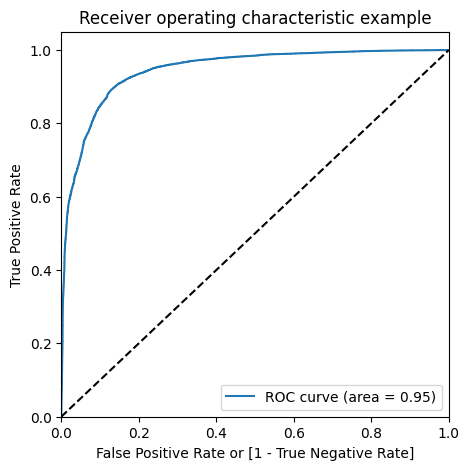

In [107]:
# Draw ROC curve
draw_roc(y_train_pred_final['churn'], y_train_pred_final['churn_prob'])

#### Find optimal cut-off point

In [108]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final['churn_prob'].map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,churn,churn_prob,customer_id,churn_predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.308200,0,0,1,1,1,1,0,0,0,0,0,0
1,0,0.144489,1,0,1,1,0,0,0,0,0,0,0,0
2,0,0.067954,2,0,1,0,0,0,0,0,0,0,0,0
3,0,0.199652,3,0,1,1,0,0,0,0,0,0,0,0
4,0,0.000023,4,0,1,0,0,0,0,0,0,0,0,0


In [109]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.777707  0.979429  0.575985
0.2   0.2  0.830808  0.964067  0.697550
0.3   0.3  0.859060  0.945888  0.772232
0.4   0.4  0.873651  0.925424  0.821878
0.5   0.5  0.881013  0.897358  0.864668
0.6   0.6  0.874236  0.849625  0.898847
0.7   0.7  0.854675  0.781215  0.928135
0.8   0.8  0.824403  0.695211  0.953596
0.9   0.9  0.786477  0.594748  0.978207


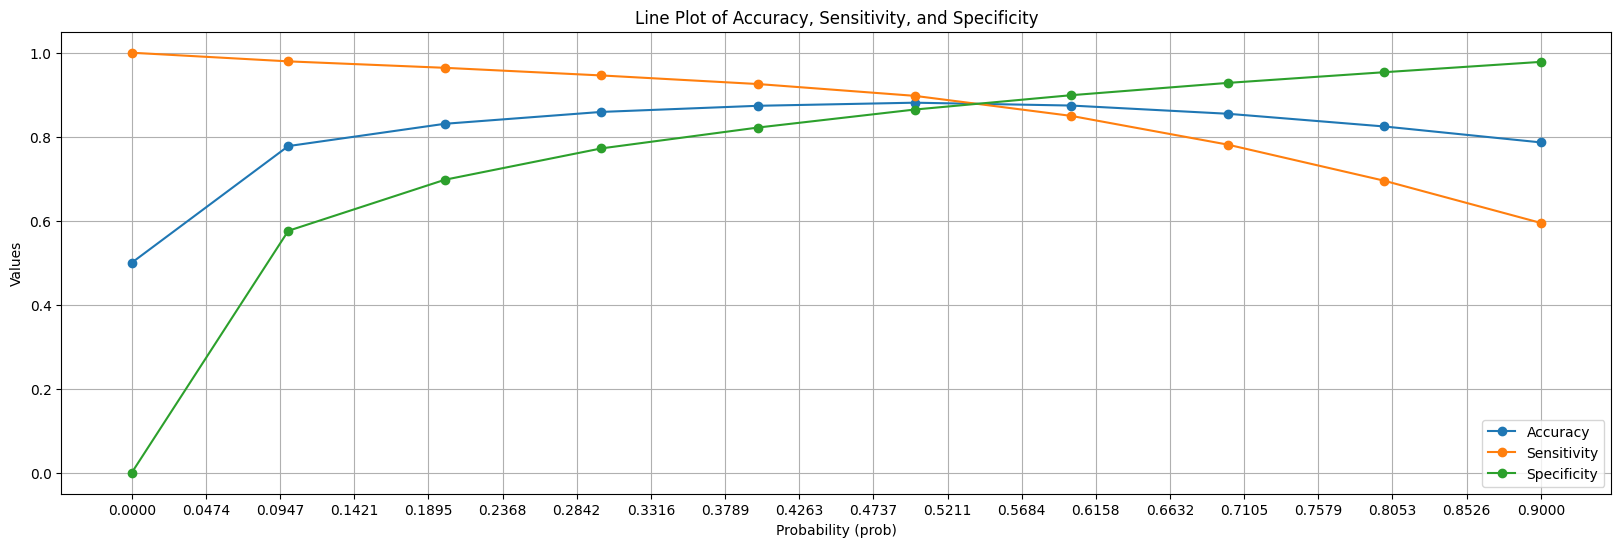

In [110]:
# Create the plot
plt.figure(figsize=(20, 6))

# Plot 'accuracy', 'sensi', and 'speci' against 'prob'
plt.plot(cutoff_df['prob'], cutoff_df['accuracy'], marker='o', label='Accuracy')
plt.plot(cutoff_df['prob'], cutoff_df['sensi'], marker='o', label='Sensitivity')
plt.plot(cutoff_df['prob'], cutoff_df['speci'], marker='o', label='Specificity')

# Set labels and title
plt.xlabel('Probability (prob)')
plt.ylabel('Values')
plt.title('Line Plot of Accuracy, Sensitivity, and Specificity')

# Xticks
num_ticks = 20
x_ticks = np.linspace(min(cutoff_df['prob']), max(cutoff_df['prob']), num_ticks)
plt.xticks(x_ticks)

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

<b><font color='green'><font size='4'>Conclusion: From the graph, we can finalize the optimum cut-off value = 0.55.</font></b>

In [111]:
# Select cutoff = 0.55 and create another column final_predicted
y_train_pred_final['final_predicted'] = y_train_pred_final['churn_prob'].map( lambda x: 1 if x > 0.55 else 0)

# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['final_predicted'])

# Print confusion matrix
confusion2 = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['final_predicted'] )
print(confusion2)

# Evaluate other metrics
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
sensitivity = TP / float(TP+FN)
print(f'sensitivity is: {sensitivity}')

# Let us calculate specificity
specificity = TN / float(TN+FP)
print(f'specificity is: {specificity}')

# Calculate false postive rate - predicting churn when customer does not have churned
fp_rate = (FP/ float(TN+FP))
print(f'false positive rate is: {fp_rate}')

# positive predictive value 
pp_value = (TP / float(TP+FP))
print(f'positive predictive value is: {pp_value}')

# Negative predictive value
np_value = (TN / float(TN+ FN))
print(f'negative predictive value is: {np_value}')

[[16618  2195]
 [ 2434 16379]]
sensitivity is: 0.8706213788337851
specificity is: 0.883325360123319
false positive rate is: 0.11667463987668102
positive predictive value is: 0.8818240551308281
negative predictive value is: 0.8722443837917279


#### Evaluate precission / recall scores by sklearn library

In [112]:
# Precision_score
preci_score = precision_score(y_train_pred_final['churn'], y_train_pred_final['final_predicted'])
print(f'precission score is: {preci_score}')

# Recall_score
rec_score = recall_score(y_train_pred_final['churn'], y_train_pred_final['final_predicted'])
print(f'recall score is: {rec_score}')

precission score is: 0.8818240551308281
recall score is: 0.8706213788337851


<b><font color='green'><font size='3'>Observation: After finding optimal cut-off, <br>(i) ROC_AUC of the train set: 0.94 <br>(ii) Recall Score of the train set: 0.87</font></b>

### Predictions on the test set

In [113]:
# Making predictions on test data
X_resampled_rfe = X_train_sm
X_resampled_rfe.drop('const', axis=1, inplace=True)

#Assigning similar columns to test data as that of train set
X_test = X_test[X_resampled_rfe.columns]
X_test.head()

##Adding the constant to X_test (as res model is based on statsmodels)
X_test_sm = sm.add_constant(X_test)
y_test_pred = res.predict(X_test_sm)

##Getting the predicted values on the test set
y_test_pred = res.predict(X_test_sm)

y_test_pred = y_test_pred.values.reshape(-1)

# Creating a dataframe with the actual churn flag and the predicted probabilities
y_test_pred_final = pd.DataFrame({'churn':y_test.values, 'churn_Prob':y_test_pred})
y_test_pred_final['customer_id'] = y_test.index

# Creating new column 'predicted' with 1 if Churn_Prob > 0.55 (optimal cut-off) else 0
y_test_pred_final['predicted'] = y_test_pred_final['churn_Prob'].map(lambda x: 1 if x > 0.55 else 0) 

# Let's evaluate Evaluation Metrics (test_data)
print('**Evaluation Metrics: Test Set (Optimal Cut-off)**')
print("******************************************************************")
print("Accuracy of Test Set: (Logistic Regression Model with RFE):")
print(metrics.accuracy_score(y_test_pred_final['churn'], y_test_pred_final['predicted']))
print("******************************************************************")

print("******************************************************************")
print("Recall score of Test Set: (Logistic Regression Model with RFE):")
print(metrics.recall_score(y_test_pred_final['churn'], y_test_pred_final['predicted']))
print("******************************************************************")

print(classification_report(y_test_pred_final['churn'], y_test_pred_final['predicted'], target_names=['Not Churned','Churned']))  # target_names=target_names
print("******************************************************************")

print("******************************************************************")
print('ROC of Test Set: (Logistic Regression Model with RFE):')
print("{:2.3}".format(metrics.roc_auc_score(y_test_pred_final['churn'], y_test_pred_final['churn_Prob'])))

**Evaluation Metrics: Test Set (Optimal Cut-off)**
******************************************************************
Accuracy of Test Set: (Logistic Regression Model with RFE):
0.8618099032441662
******************************************************************
******************************************************************
Recall score of Test Set: (Logistic Regression Model with RFE):
0.574792243767313
******************************************************************
              precision    recall  f1-score   support

 Not Churned       0.96      0.89      0.92      8063
     Churned       0.31      0.57      0.41       722

    accuracy                           0.86      8785
   macro avg       0.64      0.73      0.66      8785
weighted avg       0.91      0.86      0.88      8785

******************************************************************
******************************************************************
ROC of Test Set: (Logistic Regression Model with RFE):
0.84

<b><font color='green'><font size='3'>Observation: After finding optimal cut-off, <br>(i) ROC_AUC of the test set: 0.836 <br>(ii) Recall Score of the test set: 0.57</font></b>

##  2. XGBoost without PCA

In [115]:
df_xgbbasic = df_eda_final.copy()

### Dummy creation for tenure

In [116]:
# Create dummies for tenure attributes
dummy_tenure = pd.get_dummies(data= df_xgbbasic['tenure'])
dummy_tenure = dummy_tenure.drop('5_12_year',axis= 1)

# Adding the results to the master dataframe
df_xgbbasic = pd.concat([df_xgbbasic, dummy_tenure], axis= 1)

# Drop the tenure feature
df_xgbbasic = df_xgbbasic.drop('tenure', axis= 1)

### Train test split

In [117]:
# Convert object type attributes to int
df_xgbbasic['arpu_drop'] = df_xgbbasic['arpu_drop'].astype(int)
df_xgbbasic['onnet_mou_drop'] = df_xgbbasic['onnet_mou_drop'].astype(int)
df_xgbbasic['offnet_mou_drop'] = df_xgbbasic['offnet_mou_drop'].astype(int)
df_xgbbasic['total_og_mou_drop'] = df_xgbbasic['total_og_mou_drop'].astype(int)
df_xgbbasic['total_rech_num_drop'] = df_xgbbasic['total_rech_num_drop'].astype(int)
df_xgbbasic['total_rech_amt_drop'] = df_xgbbasic['total_rech_amt_drop'].astype(int)
df_xgbbasic['av_rech_amt_data_drop'] = df_xgbbasic['av_rech_amt_data_drop'].astype(int)
df_xgbbasic['churn'] = df_xgbbasic['churn'].astype(int)

# Train - test split
y = df_xgbbasic['churn']
X = df_xgbbasic.drop(['churn'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify= y,train_size= 0.7,random_state= 42)

#### Handle target data imbalance

#### Oversampling technique: SMOTE

In [118]:
# Instantiate SMOTE
smote_xgb = SMOTE(random_state=42)

# Fit on the training set
X_train_res, y_train_res = smote_xgb.fit_resample(X_train, y_train)

#### Feature scaling

In [119]:
# All columns
all_cols = df_xgbbasic.columns.to_list()

# target column
target_col = ['churn']

# Categorical columns
cat_cols = ['arpu_drop', 'onnet_mou_drop', 'offnet_mou_drop', 'total_og_mou_drop', 'total_rech_num_drop', 'total_rech_amt_drop', 'av_rech_amt_data_drop','0_1_year','1_2_year','2_3_year','3_5_year']

# Continuous columns
cont_cols = []
for col in all_cols:
    if col not in cat_cols:
        cont_cols.append(col)
# cont_cols = [x for x in all_cols if x not in [cat_cols,target_col]]
cont_cols.remove('churn')

# Instantiate the StandardScaler
scaler = StandardScaler()

# Apply scaler on the continuous columns in the training dataset
X_train_res[cont_cols] = scaler.fit_transform(X_train_res[cont_cols])

# Apply scaler on the continuous columns in the test dataset
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

### Model fitting

In [120]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [121]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_res, y_train_res) 

# Get our predictions
y_test_pred = xgb_cfl.predict(X_test)

In [122]:
xgb_predictions_prob = xgb_cfl.predict_proba(X_test)
xgb_predictions_prob

array([[9.9871731e-01, 1.2826768e-03],
       [9.6910858e-01, 3.0891430e-02],
       [9.9923265e-01, 7.6735165e-04],
       ...,
       [3.8099766e-02, 9.6190023e-01],
       [7.2861648e-01, 2.7138355e-01],
       [9.9463660e-01, 5.3634332e-03]], dtype=float32)

In [123]:
print('**************************************************************')
print('accuracy score of xgboost without pca: ')
print(accuracy_score(y_test, y_test_pred))
print('**************************************************************')

print('**************************************************************')
print('precission score of xgboost without pca: ')
print(precision_score(y_test, y_test_pred))
print('**************************************************************')

print('**************************************************************')
print('recall score of xgboost without pca: ')
print(recall_score(y_test, y_test_pred))
print('**************************************************************')

**************************************************************
accuracy score of xgboost without pca: 
0.9335230506545248
**************************************************************
**************************************************************
precission score of xgboost without pca: 
0.6109324758842444
**************************************************************
**************************************************************
recall score of xgboost without pca: 
0.5263157894736842
**************************************************************


## Feature importance

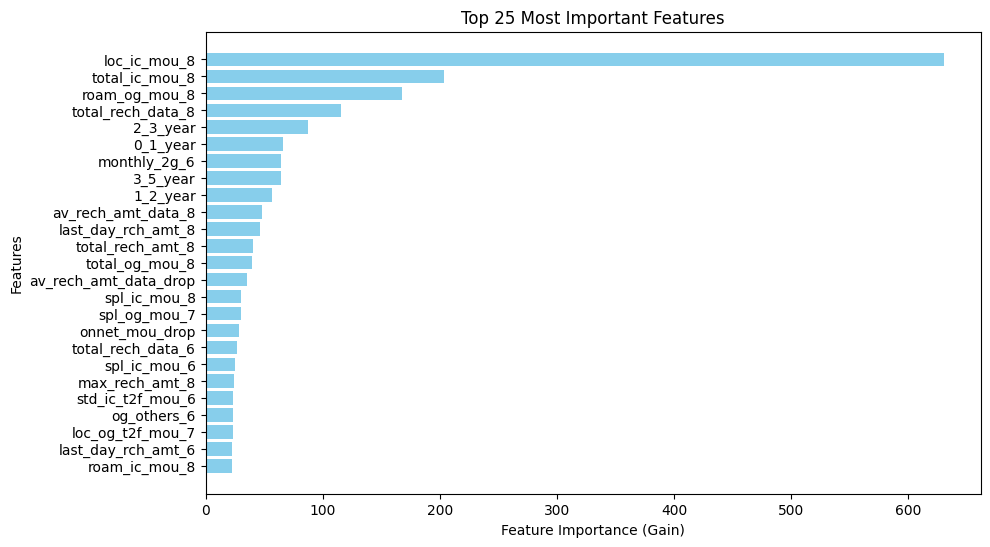

In [124]:
# Get feature importances using 'gain'
feature_importance = xgb_cfl.get_booster().get_score(importance_type='gain')

# Sort the feature importances by their value in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Extract the top N most important features (e.g., top 10 features)
top_n = 25
top_features = [feature for feature, score in sorted_feature_importance[:top_n]]
top_scores = [score for feature, score in sorted_feature_importance[:top_n]]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_scores, color='skyblue')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')
plt.title('Top {} Most Important Features'.format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()


# Conclusion:
<hr/>

Top 20 features:

1. loc_ic_mou_8
2. total_ic_mou_8
3. total_rech_data_8
4. tenure_2_3_years
5. tenure_0_1_years
6. monthly_2g_6
7. tenure_3_5_years
8. Tenure_1_2_years
9. av_rech_amt_data_8
10. last_day_rech_amt_8
11. total_og_mou_8
12. avg_rech_amt_data_drop
13. spl_ic_mou
14. spl_og_mou_7
15. onnnet_mou_drop
16. total_rech_data_6
17. spl_ic_mou_6
18. max_rech_amt_8
19. og_others_6
20. last_day_rech_amt_6

<b><font color='green'><font size='3'>Note: Important features have been extracted from the data, but mmeanwhile the model couldn`t achieve a satisfactory recall score. Hence, we will proceed with PCA and hyper-parameter tuning for the models</font></b>

## 3. Multiple models with PCA
<hr/>

1. Logistic regression
2. Random forests
3. KNN

In [177]:
df_train_pca = df_eda_final.copy()

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA

# Define the order of categories
ordered_categories = [['0_1_year', '1_2_year', '2_3_year', '3_5_year', '5_12_year']]

# Instantiate the encoder with the specified order
encoder = OrdinalEncoder(categories=ordered_categories, handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform the 'tenure' feature
df_train_pca['tenure_encoded'] = encoder.fit_transform(df_train_pca[['tenure']])

# Drop the tenure feature
df_train_pca = df_train_pca.drop('tenure', axis= 1)

In [178]:
# Convert object type attributes to labels
lab_enc = LabelEncoder()
df_train_pca['arpu_drop'] = lab_enc.fit_transform(df_train_pca['arpu_drop'])
df_train_pca['onnet_mou_drop'] = lab_enc.fit_transform(df_train_pca['onnet_mou_drop'])
df_train_pca['offnet_mou_drop'] = lab_enc.fit_transform(df_train_pca['offnet_mou_drop'])
df_train_pca['total_og_mou_drop'] = lab_enc.fit_transform(df_train_pca['total_og_mou_drop'])
df_train_pca['total_rech_num_drop'] = lab_enc.fit_transform(df_train_pca['total_rech_num_drop'])
df_train_pca['total_rech_amt_drop'] = lab_enc.fit_transform(df_train_pca['total_rech_amt_drop'])
df_train_pca['av_rech_amt_data_drop'] = lab_enc.fit_transform(df_train_pca['av_rech_amt_data_drop'])
df_train_pca['churn'] = lab_enc.fit_transform(df_train_pca['churn'])

In [179]:
# Train - test split
y = df_train_pca['churn']
X = df_train_pca.drop(['churn'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify= y,train_size= 0.7,random_state= 82)

In [180]:
# Instantiate SMOTE
smote_xgb = SMOTE(random_state=82)

# Fit on the training set
print(f'X_train, y_train shape: {X_train.shape, y_train.shape} and churn ratio in y_train= {y_train.sum()/len(y_train)}')
X_train, y_train = smote_xgb.fit_resample(X_train, y_train)
print(f'X_train, y_train shape: {X_train.shape, y_train.shape} and churn ratio in y_train= {y_train.sum()/len(y_train)}')

X_train, y_train shape: ((20498, 137), (20498,)) and churn ratio in y_train= 0.08220314176992877
X_train, y_train shape: ((37626, 137), (37626,)) and churn ratio in y_train= 0.5


In [181]:
# target column
target_col = ['churn']

# # Categorical columns
cat_cols = ['arpu_drop', 'onnet_mou_drop', 'offnet_mou_drop', 'total_og_mou_drop', 'total_rech_num_drop', 'total_rech_amt_drop', 'av_rech_amt_data_drop','tenure_encoded']
cont_cols = [i for i in X_train.columns if i not in cat_cols]


# Instantiate the StandardScaler
scaler = StandardScaler()

# Apply scaler on the continuous columns in the training dataset
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])

# Apply scaler on the continuous columns in the test dataset
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

In [182]:
# Instantiate PCA object
pca = PCA(0.95, random_state=62)
pca.fit(X_train)

pca_final = IncrementalPCA(n_components=pca.n_components_)

## Transform dependent features using PCA
X_train_trf = pca_final.fit_transform(X_train)
X_test_trf = pca_final.transform(X_test)

In [183]:
# base models without hyperparameter tuning

## Import model objects
lr_pca = LogisticRegression()
rf_pca = RandomForestClassifier()
knn_pca = KNeighborsClassifier()

## Fit models
lr_pca.fit(X_train_trf,y_train)
rf_pca.fit(X_train_trf,y_train)
knn_pca.fit(X_train_trf,y_train)

## Predict
y_test_pred_lr_pca = lr_pca.predict(X_test_trf)
y_test_pred_rf_pca = rf_pca.predict(X_test_trf)
y_test_pred_knn_pca = knn_pca.predict(X_test_trf)

## Model evaluation scores
print('*************************Accuracy Score*************************')
print('Logistic Regession with PCA test accuracy score:', round(accuracy_score(y_test, y_test_pred_lr_pca) * 100, 2),'%')
print('Random Forest with PCA test accuracy score:', round(accuracy_score(y_test, y_test_pred_rf_pca) * 100, 2),'%')
print('KNN with PCA test accuracy score:', round(accuracy_score(y_test, y_test_pred_knn_pca) * 100, 2),'%')

print('*************************Precission Score*************************')
print('Logistic Regession with PCA test precision score:', round(precision_score(y_test, y_test_pred_lr_pca) * 100, 2),'%')
print('Random Forest with PCA test precision score:', round(precision_score(y_test, y_test_pred_rf_pca) * 100, 2),'%')
print('KNN with PCA test precision score:', round(precision_score(y_test, y_test_pred_knn_pca) * 100, 2),'%')

print('*************************Recall Score*************************')
print('Logistic Regession with PCA test recall score:', round(recall_score(y_test, y_test_pred_lr_pca) * 100, 2),'%')
print('Random Forest with PCA test recall score:', round(recall_score(y_test, y_test_pred_rf_pca) * 100, 2),'%')
print('KNN with PCA test recall score:', round(recall_score(y_test, y_test_pred_knn_pca) * 100, 2),'%')


*************************Accuracy Score*************************
Logistic Regession with PCA test accuracy score: 82.5 %
Random Forest with PCA test accuracy score: 91.19 %
KNN with PCA test accuracy score: 80.54 %
*************************Precission Score*************************
Logistic Regession with PCA test precision score: 29.49 %
Random Forest with PCA test precision score: 46.8 %
KNN with PCA test precision score: 26.07 %
*************************Recall Score*************************
Logistic Regession with PCA test recall score: 81.16 %
Random Forest with PCA test recall score: 52.63 %
KNN with PCA test recall score: 74.52 %


**Accuracy Score**

Logistic Regession with PCA test accuracy score: 82.5 %

Random Forest with PCA test accuracy score: 91.19 %

KNN with PCA test accuracy score: 80.54 %

**Precission Score**

Logistic Regession with PCA test precision score: 29.49 %

Random Forest with PCA test precision score: 46.8 %

KNN with PCA test precision score: 26.07 %

**Recall Score**

Logistic Regession with PCA test recall score: 81.16 %

Random Forest with PCA test recall score: 52.63 %

KNN with PCA test recall score: 74.52 %

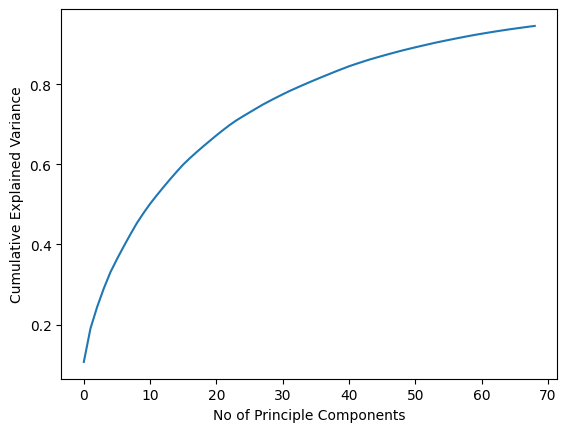

In [184]:
# Evaluate optimum number of principle components
ev_ratio_cum = np.cumsum(pca_final.explained_variance_ratio_)
plt.plot(ev_ratio_cum)
plt.xlabel('No of Principle Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Hyperparameter tuning: LogisticRegression + PCA

In [185]:
# Create a Logistic Regression model
model = LogisticRegression()

# Define hyperparameter grid for tuning
param_grid = {'C': [0.001,0.01,0.1,1,10,50,100,150,200,250]}

# Create a GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose= 3)

# Fit on training data
grid_result = grid_search.fit(X_train_trf,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [186]:
grid_result.best_params_

{'C': 10}

In [188]:
# Now we train the logistic regression model with the selected hyperparameter
lr_model_final = LogisticRegression(C=10)

# Fit the model on train data
lr_model_final.fit(X_train_trf,y_train)

## Predict
y_test_pred_hyp = lr_model_final.predict(X_test_trf)

## Model evaluation scores
print('*************************Accuracy Score*************************')
print('Logistic Regession + Hyperparameter tuned + PCA test accuracy score:', round(accuracy_score(y_test, y_test_pred_hyp) * 100, 2),'%')

print('*************************roc_auc Score*************************')
print('Logistic Regession + Hyperparameter tuned + PCA test roc_auc score:', round(roc_auc_score(y_test, y_test_pred_hyp) * 100, 2),'%')

print('*************************Recall Score*************************')
print('Logistic Regession + Hyperparameter tuned + PCA test recall score:', round(recall_score(y_test, y_test_pred_hyp) * 100, 2),'%')

*************************Accuracy Score*************************
Logistic Regession + Hyperparameter tuned + PCA test accuracy score: 82.5 %
*************************roc_auc Score*************************
Logistic Regession + Hyperparameter tuned + PCA test roc_auc score: 81.89 %
*************************Recall Score*************************
Logistic Regession + Hyperparameter tuned + PCA test recall score: 81.16 %


*************************Accuracy Score*************************

Logistic Regession + Hyperparameter tuned + PCA test accuracy score: 82.5 %

*************************Precission Score*************************

Logistic Regession + Hyperparameter tuned + PCA test roc-auc score: 81.89 %

*************************Recall Score*************************

Logistic Regession + Hyperparameter tuned + PCA test recall score: 81.16%

## Hyperparameter tuning: XGBoost + PCA using RandomizedSearchCV

In [ ]:
%%time

# Create a basic XGBoost object
xgb1 = xgb.XGBClassifier()

# Define a parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': np.arange(3,15,5), 
    'n_estimators': range(20,200,20), 
    'subsample': [0.8,0.9,1.0],
    'gamma': np.arange(0.1,0.4,0.1)
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb1, param_distributions=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)


# Fit the GridSearchCV to the data
random_search.fit(X_train_trf, y_train)

# Get the best parameters and the corresponding model
best_params = random_search.best_params_
best_xgb_classifier = random_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred = best_xgb_classifier.predict(X_test_trf)
recall = recall_score(y_test, y_test_pred)


In [191]:
# Fit the model on train data
best_xgb_classifier.fit(X_train_trf,y_train)

## Predict
y_test_pred_hyp = best_xgb_classifier.predict(X_test_trf)

## Model evaluation scores
print('*************************Accuracy Score*************************')
print('XGBoost + Hyperparameter tuned + PCA test accuracy score:', round(accuracy_score(y_test, y_test_pred_hyp) * 100, 2),'%')

print('*************************roc_auc_score Score*************************')
print('XGBoost + Hyperparameter tuned + PCA test roc_auc score:', round(roc_auc_score(y_test, y_test_pred_hyp) * 100, 2),'%')

print('*************************Recall Score*************************')
print('XGBoost + Hyperparameter tuned + PCA test recall score:', round(recall_score(y_test, y_test_pred_hyp) * 100, 2),'%')

*************************Accuracy Score*************************
XGBoost + Hyperparameter tuned + PCA test accuracy score: 84.74 %
*************************roc_auc_score Score*************************
XGBoost + Hyperparameter tuned + PCA test roc_auc score: 80.9 %
*************************Recall Score*************************
XGBoost + Hyperparameter tuned + PCA test recall score: 76.32 %


## Hyperparameter tuning: Random Forests + PCA using RandomizedSearchCV

In [ ]:
%%time

# Create a basic Random forest object
rf_pca_new = RandomForestClassifier()

# Define a parameter grid for tuning
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf_pca_new, param_distributions=param_dist, cv=5, scoring='roc_auc', n_jobs=-1)


# Fit the GridSearchCV to the data
random_search.fit(X_train_trf, y_train)

# Get the best parameters and the corresponding model
best_params = random_search.best_params_
best_rf_classifier = random_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred_rf = best_rf_classifier.predict(X_test_trf)
recall = recall_score(y_test, y_test_pred_rf)

print("Best Parameters:", best_params)
print("Test recall:", recall)

In [ ]:
# Now we train the random forest regression model with the selected hyperparameter
# Fit the model on train data
best_rf_classifier.fit(X_train_trf,y_train)

## Predict
y_test_pred_hyp_rf = best_rf_classifier.predict(X_test_trf)

## Model evaluation scores
print('*************************Accuracy Score*************************')
print('XGBoost + Hyperparameter tuned + PCA test accuracy score:', round(accuracy_score(y_test, y_test_pred_hyp_rf) * 100, 2),'%')

print('*************************roc_auc_score Score*************************')
print('XGBoost + Hyperparameter tuned + PCA test roc_auc score:', round(roc_auc_score(y_test, y_test_pred_hyp_rf) * 100, 2),'%')

print('*************************Recall Score*************************')
print('XGBoost + Hyperparameter tuned + PCA test recall score:', round(recall_score(y_test, y_test_pred_hyp_rf) * 100, 2),'%')

## Summary

In [4]:
summary = {
    'Model Name': ['Random Forests', 'XGBoost', 'Logistic Regression'],
    'Accuracy Score': ['91.78%', '84.74%', '82.5%'],
    'ROC_AUC Score': ['73.45%', '80.9%', '81.89%'],
    'Recall Score': ['46.12%','76.32%','81.16%']
}
df_summary = pd.DataFrame(summary)

df_summary.head()

,Model Name,Accuracy Score,ROC_AUC Score,Recall Score
0,Random Forests,91.78%,73.45%,46.12%
1,XGBoost,84.74%,80.9%,76.32%
2,Logistic Regression,82.5%,81.89%,81.16%


### So based on our metrics, Logistic Regression with PCA & hyperparameter tuning seems to give best results.

# Top 20 features:
<hr/>

1. loc_ic_mou_8
2. total_ic_mou_8
3. total_rech_data_8
4. tenure_2_3_years
5. tenure_0_1_years
6. monthly_2g_6
7. tenure_3_5_years
8. Tenure_1_2_years
9. av_rech_amt_data_8
10. last_day_rech_amt_8
11. total_og_mou_8
12. avg_rech_amt_data_drop
13. spl_ic_mou
14. spl_og_mou_7
15. onnnet_mou_drop
16. total_rech_data_6
17. spl_ic_mou_6
18. max_rech_amt_8
19. og_others_6
20. last_day_rech_amt_6

# Conclusions:
<hr/>

1. High incoming and outgoing call minutes in August correlate with lower churn rates.
2. Customers who recharge data services in August are less likely to churn.
3. Longer tenure customers show lower churn rates, while very short-term customers are more likely to churn.

# Suggestions to the telecom operator:
<hr/>

1. Promote data recharge offers and data-centric plans to encourage data usage.
2. Implement loyalty programs and incentives for customers with longer tenures.
3. Enhance the onboarding experience for new customers to retain them.
4. Invest in improving network quality and incoming call reliability.
5. Monitor and analyze customer usage patterns to offer personalized recommendations.
6. Stay competitive in pricing strategies, especially for high monthly charges.
7. Engage with customers through targeted promotions and ensure a high-quality customer service experience.